# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 10:53 - loss: 0.6931

  41/1875 [..............................] - ETA: 2s - loss: 0.5060   

  84/1875 [>.............................] - ETA: 2s - loss: 0.4278

 123/1875 [>.............................] - ETA: 2s - loss: 0.3920

 162/1875 [=>............................] - ETA: 2s - loss: 0.3683

 204/1875 [==>...........................] - ETA: 2s - loss: 0.3495

 248/1875 [==>...........................] - ETA: 1s - loss: 0.3341

 292/1875 [===>..........................] - ETA: 1s - loss: 0.3215

 335/1875 [====>.........................] - ETA: 1s - loss: 0.3112

 378/1875 [=====>........................] - ETA: 1s - loss: 0.3024

 422/1875 [=====>........................] - ETA: 1s - loss: 0.2944

 465/1875 [======>.......................] - ETA: 1s - loss: 0.2875

 509/1875 [=======>......................] - ETA: 1s - loss: 0.2812

 549/1875 [=======>......................] - ETA: 1s - loss: 0.2760

 592/1875 [========>.....................] - ETA: 1s - loss: 0.2709

 636/1875 [=========>....................] - ETA: 1s - loss: 0.2661

 676/1875 [=========>....................] - ETA: 1s - loss: 0.2621

 715/1875 [==========>...................] - ETA: 1s - loss: 0.2585

 754/1875 [===========>..................] - ETA: 1s - loss: 0.2551

 793/1875 [===========>..................] - ETA: 1s - loss: 0.2518

 831/1875 [============>.................] - ETA: 1s - loss: 0.2489

 869/1875 [============>.................] - ETA: 1s - loss: 0.2461

 908/1875 [=============>................] - ETA: 1s - loss: 0.2433

 952/1875 [==============>...............] - ETA: 1s - loss: 0.2404

 986/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1026/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1063/1875 [================>.............] - ETA: 1s - loss: 0.2338

1093/1875 [================>.............] - ETA: 0s - loss: 0.2321

1130/1875 [=================>............] - ETA: 0s - loss: 0.2301

1169/1875 [=================>............] - ETA: 0s - loss: 0.2281

1209/1875 [==================>...........] - ETA: 0s - loss: 0.2262

1249/1875 [==================>...........] - ETA: 0s - loss: 0.2243

1288/1875 [===================>..........] - ETA: 0s - loss: 0.2225

1327/1875 [====================>.........] - ETA: 0s - loss: 0.2208

1366/1875 [====================>.........] - ETA: 0s - loss: 0.2191

1406/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1445/1875 [======================>.......] - ETA: 0s - loss: 0.2160

1484/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1523/1875 [=======================>......] - ETA: 0s - loss: 0.2130

1558/1875 [=======================>......] - ETA: 0s - loss: 0.2118

1597/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1636/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2078

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1753/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1792/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1829/1875 [============================>.] - ETA: 0s - loss: 0.2031

1869/1875 [============================>.] - ETA: 0s - loss: 0.2019

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2017


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1022

  35/1875 [..............................] - ETA: 2s - loss: 0.1079

  74/1875 [>.............................] - ETA: 2s - loss: 0.1080

 112/1875 [>.............................] - ETA: 2s - loss: 0.1079

 150/1875 [=>............................] - ETA: 2s - loss: 0.1077

 185/1875 [=>............................] - ETA: 2s - loss: 0.1076

 220/1875 [==>...........................] - ETA: 2s - loss: 0.1076

 256/1875 [===>..........................] - ETA: 2s - loss: 0.1075

 287/1875 [===>..........................] - ETA: 2s - loss: 0.1075

 326/1875 [====>.........................] - ETA: 2s - loss: 0.1074

 365/1875 [====>.........................] - ETA: 2s - loss: 0.1073

 401/1875 [=====>........................] - ETA: 2s - loss: 0.1072

 438/1875 [======>.......................] - ETA: 1s - loss: 0.1072

 476/1875 [======>.......................] - ETA: 1s - loss: 0.1071

 508/1875 [=======>......................] - ETA: 1s - loss: 0.1070

 545/1875 [=======>......................] - ETA: 1s - loss: 0.1069

 578/1875 [========>.....................] - ETA: 1s - loss: 0.1068

 612/1875 [========>.....................] - ETA: 1s - loss: 0.1068

 638/1875 [=========>....................] - ETA: 1s - loss: 0.1067

 665/1875 [=========>....................] - ETA: 1s - loss: 0.1066

 692/1875 [==========>...................] - ETA: 1s - loss: 0.1066

 716/1875 [==========>...................] - ETA: 1s - loss: 0.1065

 743/1875 [==========>...................] - ETA: 1s - loss: 0.1065

 768/1875 [===========>..................] - ETA: 1s - loss: 0.1064

 798/1875 [===========>..................] - ETA: 1s - loss: 0.1064

 824/1875 [============>.................] - ETA: 1s - loss: 0.1063

 852/1875 [============>.................] - ETA: 1s - loss: 0.1063

 883/1875 [=============>................] - ETA: 1s - loss: 0.1062

 914/1875 [=============>................] - ETA: 1s - loss: 0.1061

 951/1875 [==============>...............] - ETA: 1s - loss: 0.1061

 988/1875 [==============>...............] - ETA: 1s - loss: 0.1060

1024/1875 [===============>..............] - ETA: 1s - loss: 0.1059

1060/1875 [===============>..............] - ETA: 1s - loss: 0.1059

1096/1875 [================>.............] - ETA: 1s - loss: 0.1058

1134/1875 [=================>............] - ETA: 1s - loss: 0.1057

1161/1875 [=================>............] - ETA: 1s - loss: 0.1057

1186/1875 [=================>............] - ETA: 1s - loss: 0.1056

1221/1875 [==================>...........] - ETA: 1s - loss: 0.1055

1255/1875 [===================>..........] - ETA: 0s - loss: 0.1055

1288/1875 [===================>..........] - ETA: 0s - loss: 0.1054

1318/1875 [====================>.........] - ETA: 0s - loss: 0.1054

1352/1875 [====================>.........] - ETA: 0s - loss: 0.1053

1388/1875 [=====================>........] - ETA: 0s - loss: 0.1052

1423/1875 [=====================>........] - ETA: 0s - loss: 0.1052

1457/1875 [======================>.......] - ETA: 0s - loss: 0.1051

1488/1875 [======================>.......] - ETA: 0s - loss: 0.1051

1523/1875 [=======================>......] - ETA: 0s - loss: 0.1050

1558/1875 [=======================>......] - ETA: 0s - loss: 0.1050

1590/1875 [========================>.....] - ETA: 0s - loss: 0.1049

1622/1875 [========================>.....] - ETA: 0s - loss: 0.1048

1658/1875 [=========================>....] - ETA: 0s - loss: 0.1048

1691/1875 [==========================>...] - ETA: 0s - loss: 0.1047

1725/1875 [==========================>...] - ETA: 0s - loss: 0.1047

1759/1875 [===========================>..] - ETA: 0s - loss: 0.1046

1794/1875 [===========================>..] - ETA: 0s - loss: 0.1046

1823/1875 [============================>.] - ETA: 0s - loss: 0.1045

1852/1875 [============================>.] - ETA: 0s - loss: 0.1045

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1044


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1007

  36/1875 [..............................] - ETA: 2s - loss: 0.0991

  63/1875 [>.............................] - ETA: 2s - loss: 0.0989

  96/1875 [>.............................] - ETA: 2s - loss: 0.0988

 132/1875 [=>............................] - ETA: 2s - loss: 0.0986

 165/1875 [=>............................] - ETA: 2s - loss: 0.0984

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 260/1875 [===>..........................] - ETA: 2s - loss: 0.0983

 293/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 461/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 602/1875 [========>.....................] - ETA: 1s - loss: 0.0981

 634/1875 [=========>....................] - ETA: 1s - loss: 0.0981

 668/1875 [=========>....................] - ETA: 1s - loss: 0.0980

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 737/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 776/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 804/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 837/1875 [============>.................] - ETA: 1s - loss: 0.0979

 877/1875 [=============>................] - ETA: 1s - loss: 0.0979

 917/1875 [=============>................] - ETA: 1s - loss: 0.0979

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1065/1875 [================>.............] - ETA: 1s - loss: 0.0978

1102/1875 [================>.............] - ETA: 1s - loss: 0.0978

1130/1875 [=================>............] - ETA: 1s - loss: 0.0978

1160/1875 [=================>............] - ETA: 1s - loss: 0.0978

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1225/1875 [==================>...........] - ETA: 0s - loss: 0.0977

1267/1875 [===================>..........] - ETA: 0s - loss: 0.0977

1304/1875 [===================>..........] - ETA: 0s - loss: 0.0977

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1842/1875 [============================>.] - ETA: 0s - loss: 0.0974

1872/1875 [============================>.] - ETA: 0s - loss: 0.0974

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0947

  31/1875 [..............................] - ETA: 3s - loss: 0.0960

  65/1875 [>.............................] - ETA: 2s - loss: 0.0960

 100/1875 [>.............................] - ETA: 2s - loss: 0.0959

 132/1875 [=>............................] - ETA: 2s - loss: 0.0958

 164/1875 [=>............................] - ETA: 2s - loss: 0.0958

 194/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 229/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 508/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 662/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 696/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 729/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 760/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 825/1875 [============>.................] - ETA: 1s - loss: 0.0958

 859/1875 [============>.................] - ETA: 1s - loss: 0.0958

 892/1875 [=============>................] - ETA: 1s - loss: 0.0958

 922/1875 [=============>................] - ETA: 1s - loss: 0.0958

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1070/1875 [================>.............] - ETA: 1s - loss: 0.0958

1104/1875 [================>.............] - ETA: 1s - loss: 0.0958

1136/1875 [=================>............] - ETA: 1s - loss: 0.0958

1165/1875 [=================>............] - ETA: 1s - loss: 0.0958

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1279/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1317/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1356/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1435/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1838/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5


   1/1875 [..............................] - ETA: 3s - loss: 0.0957

  30/1875 [..............................] - ETA: 3s - loss: 0.0943

  70/1875 [>.............................] - ETA: 2s - loss: 0.0943

 110/1875 [>.............................] - ETA: 2s - loss: 0.0944

 149/1875 [=>............................] - ETA: 2s - loss: 0.0946

 187/1875 [=>............................] - ETA: 2s - loss: 0.0947

 227/1875 [==>...........................] - ETA: 2s - loss: 0.0948

 264/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 303/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 383/1875 [=====>........................] - ETA: 1s - loss: 0.0950

 423/1875 [=====>........................] - ETA: 1s - loss: 0.0950

 463/1875 [======>.......................] - ETA: 1s - loss: 0.0950

 503/1875 [=======>......................] - ETA: 1s - loss: 0.0950

 532/1875 [=======>......................] - ETA: 1s - loss: 0.0950

 566/1875 [========>.....................] - ETA: 1s - loss: 0.0950

 606/1875 [========>.....................] - ETA: 1s - loss: 0.0950

 645/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 684/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 715/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 741/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 832/1875 [============>.................] - ETA: 1s - loss: 0.0950

 863/1875 [============>.................] - ETA: 1s - loss: 0.0951

 900/1875 [=============>................] - ETA: 1s - loss: 0.0951

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1063/1875 [================>.............] - ETA: 1s - loss: 0.0951

1104/1875 [================>.............] - ETA: 1s - loss: 0.0951

1145/1875 [=================>............] - ETA: 1s - loss: 0.0951

1186/1875 [=================>............] - ETA: 0s - loss: 0.0951

1217/1875 [==================>...........] - ETA: 0s - loss: 0.0951

1250/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1284/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1318/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1829/1875 [============================>.] - ETA: 0s - loss: 0.0951

1867/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

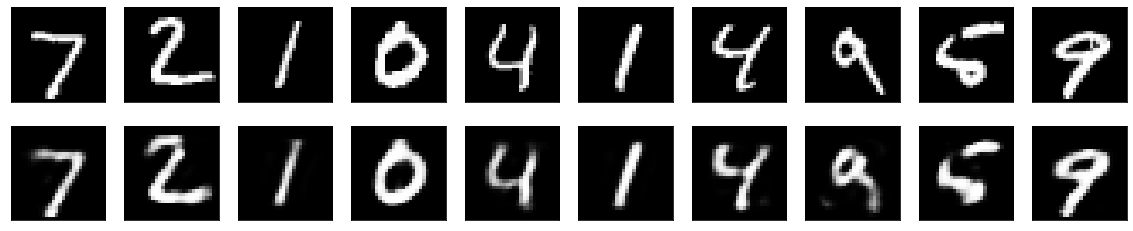

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
